In [1]:
from astropy.io import fits
from scipy import *
import numpy as np
from pylab import *

In [3]:
################ APOGESS DR14
## Number of objects: 277,371
hdulist = fits.open('allStar-l31c.2.fits')

In [21]:
################ GAIA DR2 matched to APOGEE DR14
## Number of objects: 284,395
## description: https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html
## data_gaia = loadtxt('gaia_dr2_apogee_cross.dat')
## save('gaia_dr2_apogee_cross.npy', data_gaia)

data_gaia = load('gaia_dr2_apogee_cross.npy').T
cols_gaia = ['ra', 'ra_err', 'dec', 'dec_err', 'para', 'para_err', 'pmra', 'pmra_err', 
             'pmdec', 'pmdec_err', 'ra_dec_corr', 'ra_para_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
             'dec_para_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'para_pmra_corr', 'para_pmdec_corr', 
             'pmra_pmdec_corr', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 
             'radial_velocity_error', 'j', 'j_err', 'h', 'h_err', 'k', 'k_err', 'teff', 'teff_err', 'vmacro']
gaia = lambda field: data_gaia[cols_gaia.index(field)]

In [93]:
print 'gaia data shape:',data_gaia.T.shape
print 'gaia catalogue fieds:',len(cols_gaia)
print 'gaia objects with no parallex:',sum(isnan(gaia('para')))

gaia data shape: (284394, 36)
gaia catalogue fieds: 36
gaia objects with no parallex: 9573


In [66]:
ra_gaia, dec_gaia = gaia('ra'), gaia('dec')
d_gaia = 1.0/gaia('para') ## distance in kpc

def ap2abs (mags):
    out = mags - 5.0*log10(d_gaia*1e2)
    out[isnan(out)]=-9999.0
    return out

Babs, Rabs, Gabs, Jabs, Habs, Kabs = [ap2abs (gaia(iband)) for iband in 
            ['phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag', 'j','h','k']]

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


In [7]:
ra_apo, dec_apo = hdulist[1].data['RA'], hdulist[1].data['DEC']

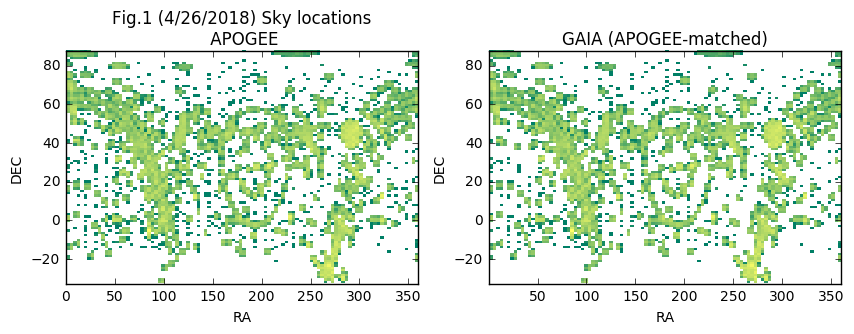

In [161]:
f, (ax1,ax2)=subplots(1,2,figsize=(10,3))
ax1.hist2d(ra_apo, dec_apo, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)
ax2.hist2d(ra_gaia, dec_gaia, bins=100,norm=mpl.colors.LogNorm(),cmap=mpl.cm.summer)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
ax1.set_title('Fig.1 (4/26/2018) Sky locations\n APOGEE')
ax2.set_title('GAIA (APOGEE-matched)')
show()

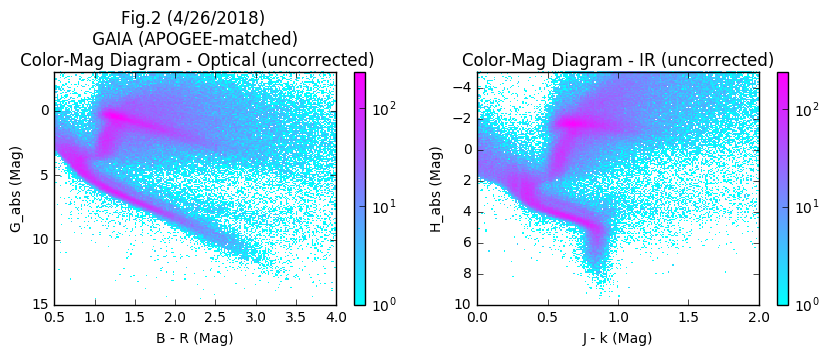

In [166]:
f, (ax1,ax2)=subplots(1,2,figsize=(10,3))
cs1=ax1.hist2d(Babs-Rabs, Gabs, bins=200, range = ((0.5,4),(-3, 15)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
ax1.set_xlabel('B - R (Mag)')
ax1.set_ylabel('G_abs (Mag)')
ax1.invert_yaxis()
ax1.set_title('Fig.2 (4/26/2018) \n GAIA (APOGEE-matched) \n Color-Mag Diagram - Optical (uncorrected)')
f.colorbar(cs1[3], ax=ax1)

cs2=ax2.hist2d(Jabs-Kabs, Habs,  bins=200, range = ((0, 2),(-5, 10)),
          norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
ax2.set_xlabel('J - k (Mag)')
ax2.set_ylabel('H_abs (Mag)')
ax2.invert_yaxis()
f.colorbar(cs2[3], ax=ax2)
ax2.set_title('Color-Mag Diagram - IR (uncorrected)')
show()

In [ ]:
############### long computation, match GAIA-APOGEE
run = 1 ## to prevent myself pressing this cell

sphere2cart = lambda ra, dec: (cos(radians(ra))*cos(radians(dec)),
                               sin(radians((ra)))*cos(radians(dec)),
                               cos(radians(dec)))
if run:
    from scipy.spatial import KDTree
    x_apo, y_apo, z_apo = sphere2cart(ra_apo, dec_apo)
    print 'coordinate transformed apogee'
    tree_apo = KDTree(zip(x_apo, y_apo))
    print 'tree built'
    x_gaia, y_gaia, z_gaia = sphere2cart(ra_gaia, dec_gaia)
    print 'coordinate transformed gaia'
    #tree_gaia = KDTree(zip(ra_gaia, dec_gaia))
    d_nearest, idx_nearest = tree_apo.query(zip(x_gaia, y_gaia, z_gaia))

In [96]:
print 'APOGEE object with GAIA match:',len(unique(idx_nearest))
print 'APOGEE object total:',len(ra_apo)
print 'GAIA objects with APOGEE match:', len(ra_gaia)
print 'GAIA objects with multiples (to APO):',len(ra_gaia)-len(unique(idx_nearest))

APOGEE object with GAIA match: 252336
APOGEE object total: 277371
GAIA objects with APOGEE match: 284394
GAIA objects with multiples (to APO): 32058


In [97]:
d_pairs = sqrt((dec_gaia-dec_apo[idx_nearest])**2 + 
           (cos(radians(dec_gaia))*ra_gaia - 
            cos(radians(dec_apo[idx_nearest]))*ra_apo[idx_nearest])**2)*3600.0

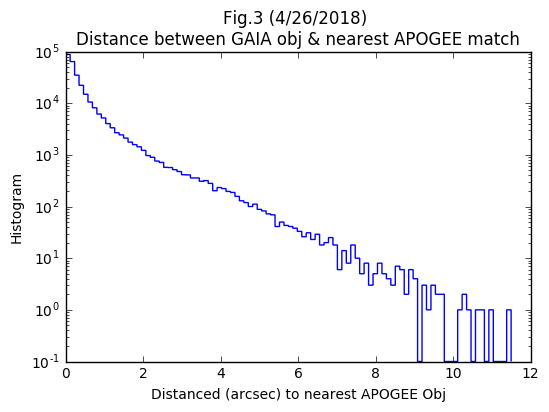

In [98]:
f, ax = subplots(1,1,figsize=(6,4))
ax.hist(d_pairs, bins=100,log=1,histtype='step')
ax.set_title('Fig.3 (4/26/2018) \nDistance between GAIA obj & nearest APOGEE match')
ax.set_xlabel('Distanced (arcsec) to nearest APOGEE Obj')
ax.set_ylabel('Histogram')
show()

In [104]:
amax(d_nearest)*3600/2/pi

3.8278209672278631

In [106]:
############ look at RV_FWHM, MAG_ABS plane, after removing tellurics
cut_telluric =logical_not (hdulist[1].data['APOGEE_TARGET2'][idx_nearest] & 2**9)
cut_logg     =(hdulist[1].data['LOGG'][idx_nearest]<3.8) & (hdulist[1].data['LOGG'][idx_nearest]>-10)
cut_teff     =(hdulist[1].data['TEFF'][idx_nearest]<5000) 
#cut_JK       =(hdulist[1].data['J'][idx_nearest]-hdulist[1].data['K'][idx_nearest] > 0.5)
classes = hdulist[1].data['ASPCAP_CLASS'][idx_nearest]
cut_class    =(classes=='GKg_a')+(classes=='GKg_b')+(classes=='GKg_c')+(classes=='GKg_d')

In [108]:
RV = hdulist[1].data['RV_CCFWHM'][idx_nearest]

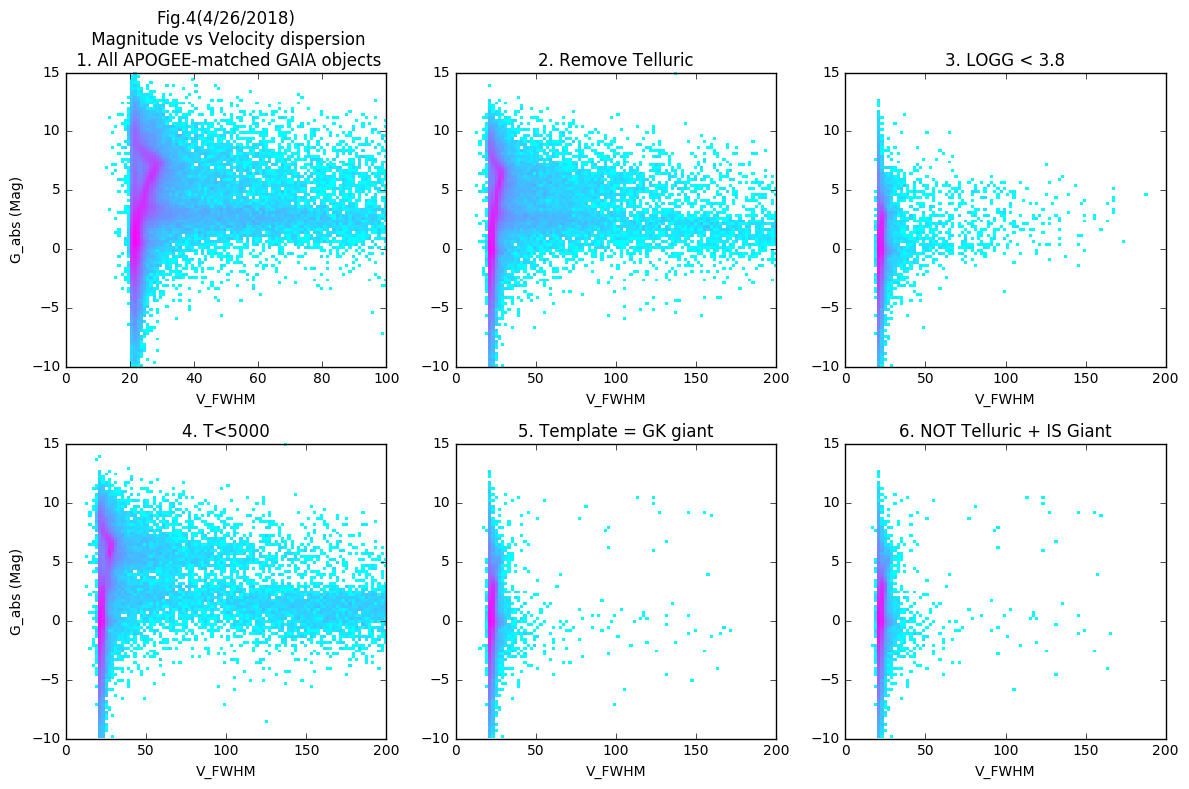

In [165]:
labels_arr = ['ALL','Remove Telluric', 'LOGG < 3.8', 'T<5000', 
              'Template = GK giant', 'NOT Telluric + IS Giant']
f, axes = subplots(2,3,figsize=(12,8))
axes=axes.flatten()

#colorbar(CB)
i=0
for icut in [1, cut_telluric, cut_logg, cut_teff, cut_class, cut_telluric*cut_class]:
    axes[i].set_title(str(i+1)+'. '+labels_arr[i], fontsize=12)
    axes[i].set_xlabel('V_FWHM')
    if i in [0,3]: axes[i].set_ylabel('G_abs (Mag)')
    if i==0:
        cs=axes[i].hist2d(RV, Gabs, bins=100, range=((0,100),(-10, 15)),
                       norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    else:
        cs=axes[i].hist2d(RV[where(icut)], Rabs[where(icut)], bins=100, range=((0,200),(-10, 15))
                      ,norm=mpl.colors.LogNorm(), cmap=mpl.cm.cool)
    #f.colorbar(cs[3], ax=axes[i])
    i+=1
axes[0].set_title('Fig.4(4/26/2018)\n Magnitude vs Velocity dispersion\n 1. All APOGEE-matched GAIA objects', fontsize=12)
plt.tight_layout()
show()

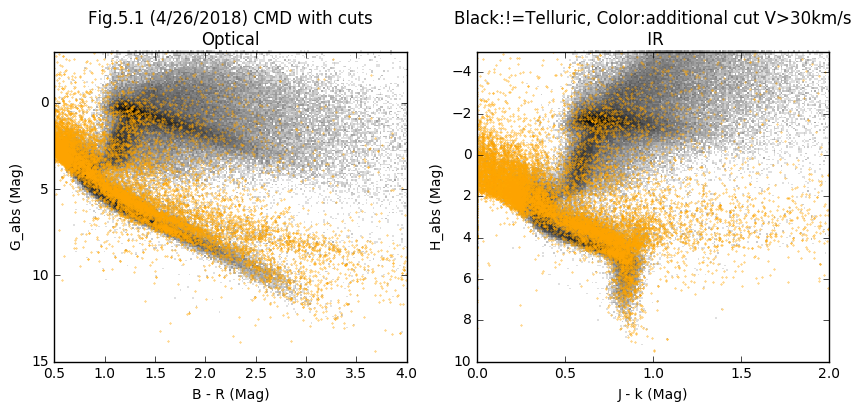

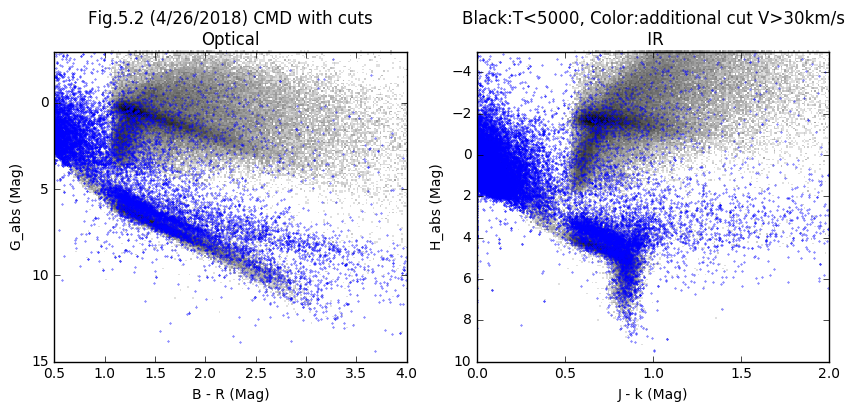

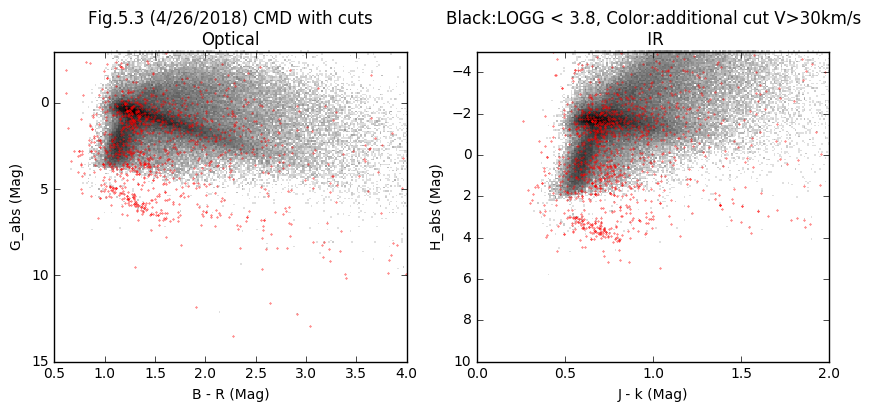

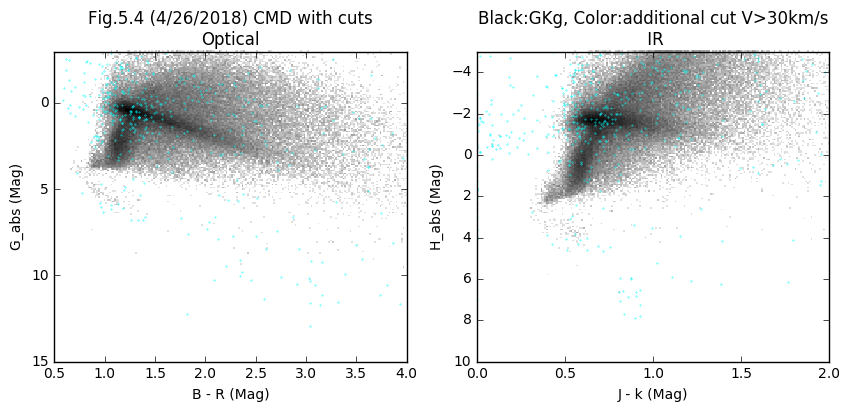

In [200]:
colors = ['orange','blue','red','cyan']
labels = ['!=Telluric', 'T<5000', 'LOGG < 3.8','GKg']
i=0
seed(5)
for icut in [cut_telluric, cut_teff, cut_logg, cut_class]:

    f, (ax1,ax2)=subplots(1,2,figsize=(10,4))
    ax1.hist2d( (Babs-Rabs)[icut], Gabs[icut], bins=200, range = ((0.5,4),(-3, 15)),
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)
    ax2.hist2d((Jabs-Kabs)[icut], Habs[icut],  bins=200, range = ((0, 2),(-5, 10)),
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)

    icolor=colors[i]#rand(3)
    iidx = where((RV>30.0)*icut)
    ax1.scatter((Babs-Rabs)[iidx],Gabs[iidx], c=icolor, edgecolors='face',s=0.1,label=labels[i])
    ax2.scatter((Jabs-Kabs)[iidx],Habs[iidx], c=icolor, edgecolors='face',s=0.1,label=labels[i])
    ax1.set_xlabel('B - R (Mag)')
    ax1.set_ylabel('G_abs (Mag)')
    ax1.invert_yaxis()

    ax1.set_title('Fig.5.%i (4/26/2018) CMD with cuts\nOptical'%(i+1))
    #ax1.legend(loc=3, frameon=1, fontsize=8)

    ax2.set_xlabel('J - k (Mag)')
    ax2.set_ylabel('H_abs (Mag)')
    ax2.invert_yaxis()
    ax2.set_title('Black:%s, Color:additional cut V>30km/s\n IR'%(labels[i]))
    i+=1

    show()